In [1]:
import numpy as np 
import pandas as pd
import os
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers.experimental import RMSprop
import tensorflow as tf
from keras.preprocessing import image

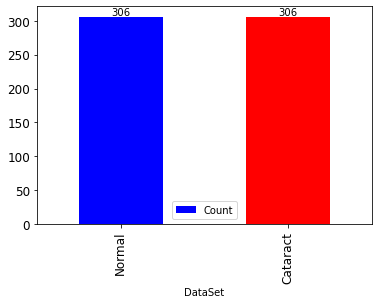

In [3]:
nor = len(image_paths['train_normal'])+len(image_paths['test_normal'])
cat = len(image_paths['train_cataract'])+len(image_paths['test_cataract'])
df = pd.DataFrame({'DataSet': ['Normal', 'Cataract'], 'Count': [nor, cat]})
bargraph = df.plot.bar(x = 'DataSet', y = 'Count', fontsize='12', color=['blue','red'])
# print(nor, cat)
for bars in bargraph.containers:
    bargraph.bar_label(bars)

In [4]:
training_dir = "C:/Users/Varun/Documents/Projects/DIP project 6th sem/data/train"
image_size = (55, 94, 3)
target_size = (55, 94)
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size = target_size,
    class_mode = 'binary'
)

model = Sequential([
    Conv2D(16, (3,3), activation='relu',input_shape=image_size),
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Found 491 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 53, 92, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 46, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 44, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 22, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8448)              0         
                                                                 
 dense (Dense) 

In [5]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer=RMSprop(lr=0.001),
    metrics=['accuracy']
)
history = model.fit_generator(
    train_generator,
    epochs=50
)

C:\Users\Varun\AppData\Local\Temp\ipykernel_37508\1784609991.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
16/16 [==============================] - 26s 1s/step - loss: 0.6751 - accuracy: 0.6395
Epoch 2/50
16/16 [==============================] - 14s 842ms/step - loss: 0.5268 - accuracy: 0.7291
Epoch 3/50
16/16 [==============================] - 14s 879ms/step - loss: 0.4301 - accuracy: 0.8289
Epoch 4/50
16/16 [==============================] - 13s 787ms/step - loss: 0.3660 - accuracy: 0.8330
Epoch 5/50
16/16 [==============================] - 13s 834ms/step - loss: 0.3162 - accuracy: 0.8595
Epoch 6/50
16/16 [==============================] - 13s 811ms/step - loss: 0.2775 - accuracy: 0.8880
Epoch 7/50
16/16 [==============================] - 15s 907ms/step - loss: 0.3070 - accuracy: 0.8717
Epoch 8/50
16/16 [==============================] - 13s 820ms/step - loss: 0.2358 - accuracy: 0.8982
Epoch 9/50
16/16 [==============================] - 14s 881ms/step - loss: 0.1806 - accuracy: 0.9328
Epoch 10/50
16/16 [==============================] - 13s 834ms/step - loss: 0.1857 - accuracy:

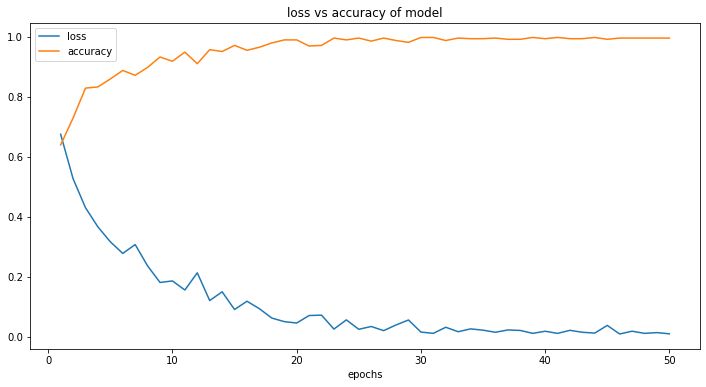

In [6]:
epochs = range(1, 51)
plt.figure(figsize=(12, 6))
plt.title("loss vs accuracy of model")
plt.plot(epochs, history.history['loss'], label='loss')
plt.plot(epochs, history.history['accuracy'], label='accuracy')
plt.xlabel("epochs")
plt.legend()

In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)
label = train_generator.class_indices
print(label)

INFO:tensorflow:Assets written to: C:\Users\Varun\AppData\Local\Temp\tmpwuqzm6_v\assets


INFO:tensorflow:Assets written to: C:\Users\Varun\AppData\Local\Temp\tmpwuqzm6_v\assets


{'cataract': 0, 'normal': 1}


## Test Case 1

1/1 [==============================] - 0s 126ms/step
actual class : normal
predicted class : normal


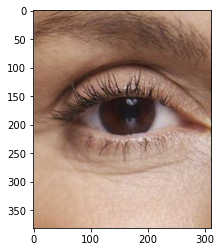

In [8]:
path = image_paths["test_normal"][1]
img = Image.open(path)
plt.imshow(np.array(img))
img = np.array(img.resize((94, 55)))
img = np.expand_dims(img, axis=0)
pred = model.predict(img)
print("actual class : normal")
print(f"predicted class : {'normal' if pred[0] > 0.5 else 'cataract'}")

## Test Case 2

1/1 [==============================] - 0s 40ms/step
actual class : cataract
predicted class : cataract


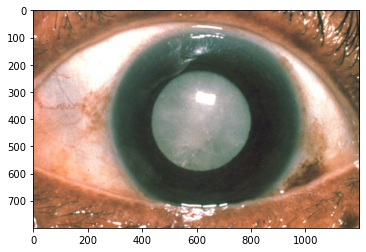

In [9]:
path = image_paths["test_cataract"][0]
img = Image.open(path)
plt.imshow(np.array(img))
img = np.array(img.resize((94, 55)))
img = np.expand_dims(img, axis=0)
pred = model.predict(img)
print("actual class : cataract")
print(f"predicted class : {'normal' if pred[0] > 0.5 else 'cataract'}")

# Evaluation of Model

In [10]:
def _predict(model, path):
    img = np.array(Image.open(path).resize((94, 55)))
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    if pred[0] > 0.5:
        return 'normal'
    else:
        return 'cataract'

def evaluate(model, normal_path, cataract_path):
    normal_pred = []
    cataract_pred = []
    for normal, cataract in zip(normal_path, cataract_path):
        res_cataract = _predict(model, cataract)
        cataract_pred.append(res_cataract)
        
        res_normal = _predict(model, normal)
        normal_pred.append(res_normal)
    
    return normal_pred, cataract_pred

both_size = min(len(image_paths["test_normal"]), len(image_paths["test_cataract"]))
cataract_test_path = image_paths["test_cataract"][:both_size]
normal_test_path = image_paths["test_normal"][:both_size]
normal_pred, cataract_pred = evaluate(model, image_paths["test_normal"], image_paths["test_cataract"])

pred_df = pd.DataFrame()
pred_df["relative_path"] = normal_test_path + cataract_test_path
pred_df["actual_class"] = ["normal"]*len(normal_test_path) + ["cataract"]*len(cataract_test_path)
pred_df["predicted_class"] = normal_pred + cataract_pred

1/1 [==============================] - 0s 17ms/step


In [12]:
tp = tn = fp = fn = 0
for actual, predicted in zip(list(pred_df['actual_class']), list(pred_df['predicted_class'])):
    if actual == 'normal' and predicted == 'normal':
        tp = tp + 1
    elif actual == 'cataract' and predicted == 'cataract':
        tn = tn + 1
    elif actual == 'normal' and predicted == 'cataract':
        fp = fp + 1
    elif actual == 'cataract' and predicted == 'normal':
        fn = fn + 1
        
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

evaluation_summary = pd.DataFrame()
evaluation_summary["Model"] = ["CNN Sequential"]
evaluation_summary["Accuracy"] = [accuracy]
evaluation_summary["Precision"] = [precision]
evaluation_summary["Recall"] = [recall]
evaluation_summary["F1 Score"] = [f1]

In [13]:
evaluation_summary

,Model,Accuracy,Precision,Recall,F1 Score
0,CNN Sequential,0.925,0.883333,0.963636,0.921739


# Model Comparision

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [15]:
# Prepare data for SVM and logistic regression models
X = []
y = []
for path in image_paths["train_normal"]:
    img = Image.open(path).resize((94, 55))
    X.append(np.array(img))
    y.append(0)
for path in image_paths["train_cataract"]:
    img = Image.open(path).resize((94, 55))
    X.append(np.array(img))
    y.append(1)

X = np.array(X) / 255.0
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM model
svm_model = svm.SVC()
svm_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Train logistic regression model
lr_model = LogisticRegression()
lr_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Evaluate logistic regression model on test data
lr_predictions = lr_model.predict(X_test.reshape(X_test.shape[0], -1))
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_precision = precision_score(y_test, lr_predictions)
lr_recall = recall_score(y_test, lr_predictions)
lr_f1 = f1_score(y_test, lr_predictions)

# Evaluate SVM model on test data
svm_predictions = svm_model.predict(X_test.reshape(X_test.shape[0], -1))
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions)
svm_f1 = f1_score(y_test, svm_predictions)

C:\Users\Varun\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
from tabulate import tabulate
table = [['Model', 'Acuraccy', 'Precision', 'Recall', 'F1 Score'], 
         ['CNN Sequential', accuracy, precision, recall, f1], 
         ['SVM', svm_accuracy, svm_precision, svm_recall, svm_f1], 
         ['Logistic Regression', lr_accuracy, lr_precision, lr_recall, lr_f1]]
print(tabulate(table, headers='firstrow', tablefmt='grid'))

+---------------------+------------+-------------+----------+------------+
| Model               |   Acuraccy |   Precision |   Recall |   F1 Score |
+=====================+============+=============+==========+============+
| CNN Sequential      |   0.925    |    0.883333 | 0.963636 |   0.921739 |
+---------------------+------------+-------------+----------+------------+
| SVM                 |   0.929293 |    0.942308 | 0.924528 |   0.933333 |
+---------------------+------------+-------------+----------+------------+
| Logistic Regression |   0.888889 |    0.862069 | 0.943396 |   0.900901 |
+---------------------+------------+-------------+----------+------------+
